[23:11:52] Building k-grid for N=192
[23:11:52] Generating random real fields and imposing spectral shape (approx k^-5/3).
[23:11:56] Applying solenoidal projection (in Fourier space).
[23:11:58] Velocity field generated in 6.3s. Mean KE density computing...
[23:12:00] Mean kinetic energy density: 9.537250e+17
[23:12:14] Saved velocity_192.npz
[23:12:14] Computing spectral gradients (full grid).
[23:12:22] Gradients computed in 8.1s
[23:12:22] Downsampling by factor DS=4 for invariants (to compute features on (48)^3 points).
[23:12:22] Computing lambda2 (this takes a moment on the downsampled grid)...
[23:12:22] Flattening feature vectors and standardizing...
[23:12:22] Feature matrix shape: (110592, 4) (110592 samples)
[23:12:22] Running KMeans (k=12) on 110592 samples...
[23:12:27] KMeans completed in 5.1s
[23:12:27] N_eff (cutoff 0.5%): 12
[23:12:27] Top 5 cluster volumes (%) (downsampled fractions): 6.27, 15.17, 9.80, 6.66, 12.44
[23:12:27] Saving CSV, NPZ and report...
[23:12:41] 

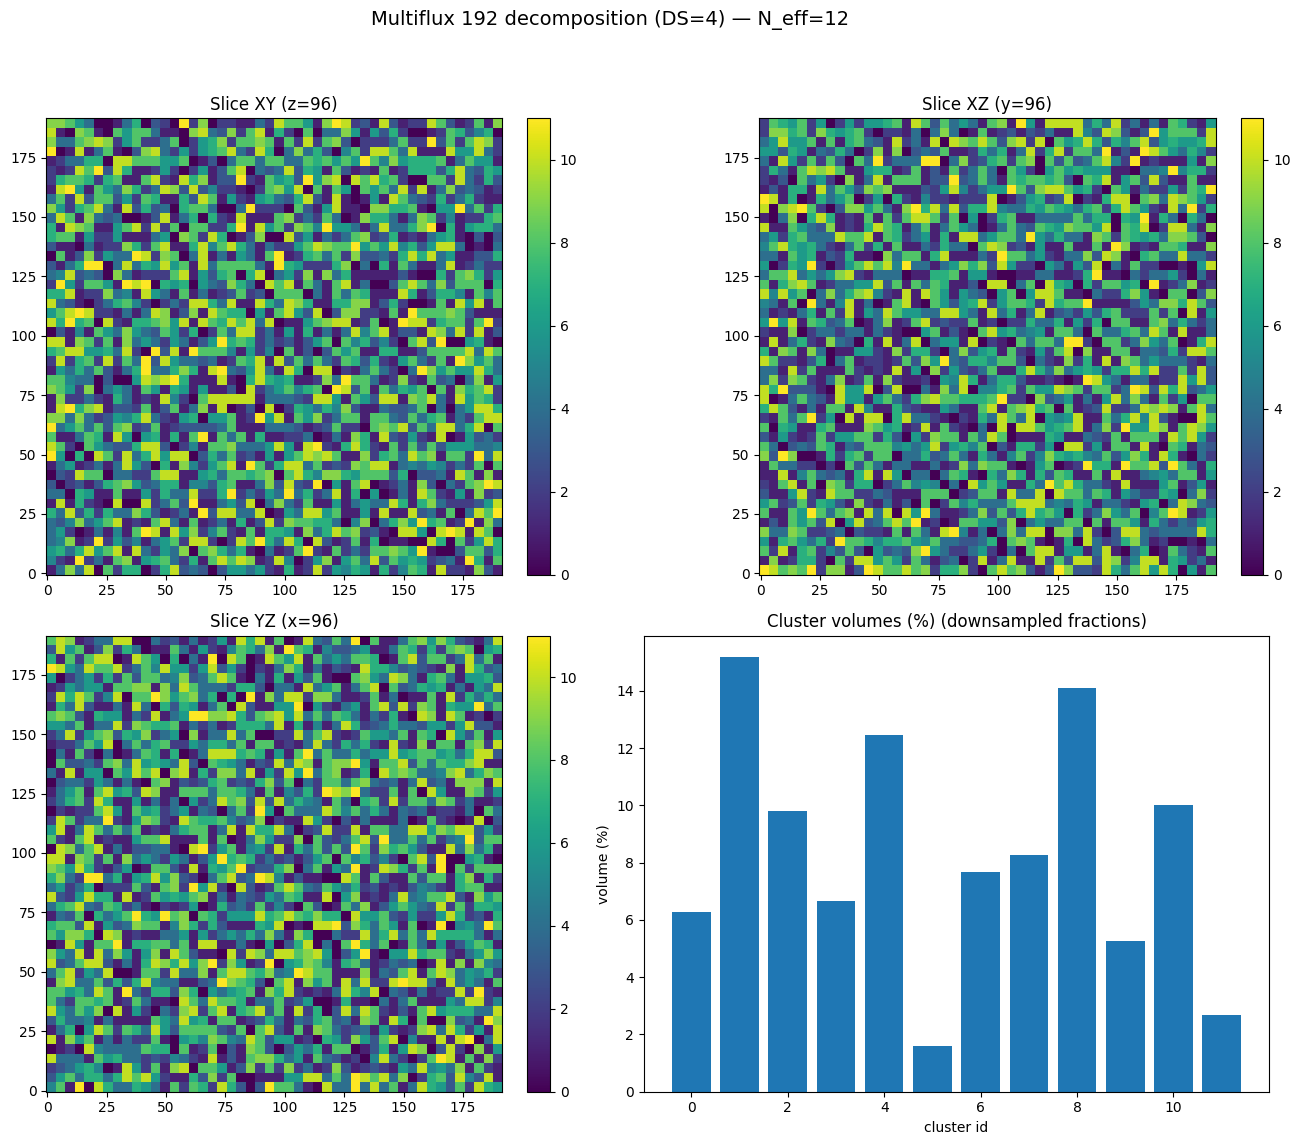

[23:12:45] Saved figure to output_multiflux_192/multiflux_slices_and_hist_192.png


ModuleNotFoundError: No module named 'imageio'

In [2]:
# -*- coding: utf-8 -*-
# Multiflux 192^3 simulation + multiflux decomposition (Jupyter-ready)
# Licensed under CC BY-NC-SA 4.0
#
# Paste this entire block into a single Jupyter cell and run.
# Requirements: numpy, scipy, scikit-learn, matplotlib
# Notes: uses downsampling DS to compute invariants+clustering to keep memory/time practical.

import os, time, json
import numpy as np
from scipy.fft import fftn, ifftn, fftfreq
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# -------------------------
# Parameters (edit if needed)
# -------------------------
N = 192               # grid (N^3)
L = 2 * np.pi
SEED = 42
K_CLUSTERS = 12
DS = 4                # downsample factor for invariants/clustering (DS=4 => 48^3 features)
VOLUME_CUTOFFS = [0.001, 0.002, 0.005, 0.01, 0.02]
OUTDIR = "output_multiflux_192"
SAVE_PLOTS = True
VERBOSE = True

# create output dir
os.makedirs(OUTDIR, exist_ok=True)

np.random.seed(SEED)

def log(msg):
    if VERBOSE:
        print(f"[{time.strftime('%H:%M:%S')}] {msg}")

# -------------------------
# 1) k-grid and helpers
# -------------------------
log(f"Building k-grid for N={N}")
kx = 2 * np.pi * fftfreq(N, d=L/N)
ky = 2 * np.pi * fftfreq(N, d=L/N)
kz = 2 * np.pi * fftfreq(N, d=L/N)
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
K2 = KX**2 + KY**2 + KZ**2
K2 += 1e-30
K = np.sqrt(K2)
mask = K2 > 0

# -------------------------
# 2) Generate random real fields in physical space -> scale in Fourier
# -------------------------
log("Generating random real fields and imposing spectral shape (approx k^-5/3).")
t0 = time.time()

# create three real Gaussian fields in physical space
u0 = np.random.randn(N, N, N)
v0 = np.random.randn(N, N, N)
w0 = np.random.randn(N, N, N)

# transform to spectral
u_hat = fftn(u0)
v_hat = fftn(v0)
w_hat = fftn(w0)

# apply spectral scaling: multiply by K**(-5/6) to approximate E(k) ~ k^-5/3
scale = np.where(mask, K**(-5/6), 0.0)
u_hat = u_hat * scale
v_hat = v_hat * scale
w_hat = w_hat * scale

# -------------------------
# 3) Solenoidal projection in Fourier space
# -------------------------
log("Applying solenoidal projection (in Fourier space).")
k_dot = KX * u_hat + KY * v_hat + KZ * w_hat
u_hat = u_hat - KX * (k_dot / K2)
v_hat = v_hat - KY * (k_dot / K2)
w_hat = w_hat - KZ * (k_dot / K2)

# ensure reality (hermitian) by taking inverse FFT of current complex fields -> should be real
# Convert back to physical space
u = np.real(ifftn(u_hat))
v = np.real(ifftn(v_hat))
w = np.real(ifftn(w_hat))

t1 = time.time()
log(f"Velocity field generated in {t1-t0:.1f}s. Mean KE density computing...")

KE_mean = 0.5 * np.mean(u*u + v*v + w*w)
log(f"Mean kinetic energy density: {KE_mean:.6e}")

# Save raw velocity (optionally can be large)
np.savez_compressed(os.path.join(OUTDIR, "velocity_192.npz"), u=u, v=v, w=w)
log("Saved velocity_192.npz")

# -------------------------
# 4) Spectral gradients (compute on full grid, then downsample)
# -------------------------
log("Computing spectral gradients (full grid).")
t0 = time.time()

def grad_fft_field(f):
    fhat = fftn(f)
    fx = np.real(ifftn(1j * KX * fhat))
    fy = np.real(ifftn(1j * KY * fhat))
    fz = np.real(ifftn(1j * KZ * fhat))
    return fx, fy, fz

du_dx, du_dy, du_dz = grad_fft_field(u)
dv_dx, dv_dy, dv_dz = grad_fft_field(v)
dw_dx, dw_dy, dw_dz = grad_fft_field(w)

t1 = time.time()
log(f"Gradients computed in {t1-t0:.1f}s")

# -------------------------
# 5) Compute invariants on downsampled grid
# -------------------------
log(f"Downsampling by factor DS={DS} for invariants (to compute features on ({N//DS})^3 points).")
inds = slice(0, N, DS)
u_s = u[inds, inds, inds]
v_s = v[inds, inds, inds]
w_s = w[inds, inds, inds]

du_dx_s = du_dx[inds, inds, inds]
du_dy_s = du_dy[inds, inds, inds]
du_dz_s = du_dz[inds, inds, inds]
dv_dx_s = dv_dx[inds, inds, inds]
dv_dy_s = dv_dy[inds, inds, inds]
dv_dz_s = dv_dz[inds, inds, inds]
dw_dx_s = dw_dx[inds, inds, inds]
dw_dy_s = dw_dy[inds, inds, inds]
dw_dz_s = dw_dz[inds, inds, inds]

# vorticity components (on downsampled grid)
omega_x = dw_dy_s - dv_dz_s
omega_y = du_dz_s - dw_dx_s
omega_z = dv_dx_s - du_dy_s
vort_mag = np.sqrt(omega_x**2 + omega_y**2 + omega_z**2)

# helicity
helicity = u_s * omega_x + v_s * omega_y + w_s * omega_z

# gradient tensor A_ij at downsampled points
# shape (3,3,n,n,n)
A = np.array([
    [du_dx_s, du_dy_s, du_dz_s],
    [dv_dx_s, dv_dy_s, dv_dz_s],
    [dw_dx_s, dw_dy_s, dw_dz_s]
])

# symmetric and antisymmetric parts
S = 0.5 * (A + np.transpose(A, (1,0,2,3,4)))
Omega = 0.5 * (A - np.transpose(A, (1,0,2,3,4)))

tr_Omega2 = np.sum(Omega**2, axis=(0,1))
tr_S2 = np.sum(S**2, axis=(0,1))
Q = 0.5 * (tr_Omega2 - tr_S2)

# compute M = S^2 + Omega^2 and lambda2 via eigvalsh
log("Computing lambda2 (this takes a moment on the downsampled grid)...")
S2 = np.einsum('il...,lj...->ij...', S, S)
Omega2 = np.einsum('il...,lj...->ij...', Omega, Omega)
M = S2 + Omega2
M = np.moveaxis(M, [0,1], [-2,-1])  # shape (n,n,n,3,3)
eigvals = np.linalg.eigvalsh(M)     # shape (n,n,n,3)
lambda2 = np.sort(eigvals, axis=-1)[..., -2]

# flatten features
log("Flattening feature vectors and standardizing...")
features = np.column_stack([
    vort_mag.ravel(),
    Q.ravel(),
    lambda2.ravel(),
    helicity.ravel()
])
# standardize
means = features.mean(axis=0)
stds = features.std(axis=0) + 1e-12
X = (features - means) / stds

n_points = X.shape[0]
log(f"Feature matrix shape: {X.shape} ({n_points} samples)")

# -------------------------
# 6) Clustering (KMeans++)
# -------------------------
log(f"Running KMeans (k={K_CLUSTERS}) on {n_points} samples...")
t0 = time.time()
kmeans = KMeans(n_clusters=K_CLUSTERS, n_init=20, max_iter=500, random_state=SEED)
labels_flat = kmeans.fit_predict(X)
t1 = time.time()
log(f"KMeans completed in {t1-t0:.1f}s")

# reshape labels to downsampled grid
n = N // DS
labels_ds = labels_flat.reshape((n, n, n))

# compute cluster volumes in fraction of full domain (account for downsample)
counts = np.bincount(labels_flat, minlength=K_CLUSTERS)
volumes = counts / float(n_points)   # fraction of downsampled domain
# approximate fraction of full domain (same fraction)
volumes_full_frac = volumes.copy()

# N_eff for default cutoff 0.5%
def compute_Neff(counts, total_points, cutoff_frac):
    return int(np.sum(counts > cutoff_frac * total_points))

N_eff_default = compute_Neff(counts, n_points, 0.005)

log(f"N_eff (cutoff 0.5%): {N_eff_default}")
log("Top 5 cluster volumes (%) (downsampled fractions): " + ", ".join(f"{100*v:.2f}" for v in volumes[:5]))

# N_eff for various cutoffs
N_eff_vs_cut = {c: compute_Neff(counts, n_points, c) for c in VOLUME_CUTOFFS}

# -------------------------
# 7) Save results (CSV, NPZ, report)
# -------------------------
log("Saving CSV, NPZ and report...")
csv_path = os.path.join(OUTDIR, "cluster_volumes_192.csv")
with open(csv_path, "w") as f:
    f.write("cluster_id,count,volume_fraction\n")
    for cid, cnt, vol in zip(range(K_CLUSTERS), counts, volumes_full_frac):
        f.write(f"{cid},{int(cnt)},{vol:.8f}\n")

npz_path = os.path.join(OUTDIR, "multiflux_192_data.npz")
np.savez_compressed(npz_path,
                    u=u, v=v, w=w,
                    vort_mag=vort_mag, Q=Q, lambda2=lambda2,
                    helicity=helicity, labels_ds=labels_ds,
                    meta=dict(N=N, L=L, seed=SEED, k_clusters=K_CLUSTERS, DS=DS))
report_path = os.path.join(OUTDIR, "report.txt")
with open(report_path, "w") as f:
    f.write("Multiflux HIT 192 run report\n")
    f.write(f"Grid: {N}^3; L={L}; seed={SEED}; k_clusters={K_CLUSTERS}\n")
    f.write(f"Mean kinetic energy density: {KE_mean:.6e}\n")
    f.write(f"N_eff (cutoff 0.50%): {N_eff_default}\n")
    f.write("Top 5 cluster volumes (%): " + ", ".join(f"{100*v:.2f}" for v in volumes[:5]) + "\n")
    f.write("N_eff vs cutoffs:\n")
    for c, ne in N_eff_vs_cut.items():
        f.write(f"  cutoff {c*100:.2f}% -> N_eff = {ne}\n")

log(f"Saved CSV: {csv_path}")
log(f"Saved NPZ: {npz_path}")
log(f"Saved report: {report_path}")

# -------------------------
# 8) Visualizations
# -------------------------
log("Generating and saving visualizations (slices + histogram).")
mid = N // 2

# Full-res slice labels by nearest-neighbor upsample of labels_ds
# We'll expand labels_ds to full grid by simple repeat
labels_full_approx = np.repeat(np.repeat(np.repeat(labels_ds, DS, axis=0), DS, axis=1), DS, axis=2)
labels_full_approx = labels_full_approx[:N, :N, :N]  # crop if needed

# Composite figure: XY, XZ, YZ + histogram of volumes
fig, axes = plt.subplots(2,2, figsize=(14,12))
im0 = axes[0,0].imshow(labels_full_approx[:, :, mid], origin='lower', interpolation='nearest')
axes[0,0].set_title(f"Slice XY (z={mid})")
plt.colorbar(im0, ax=axes[0,0], fraction=0.046, pad=0.04)

im1 = axes[0,1].imshow(labels_full_approx[:, mid, :].T, origin='lower', interpolation='nearest')
axes[0,1].set_title(f"Slice XZ (y={mid})")
plt.colorbar(im1, ax=axes[0,1], fraction=0.046, pad=0.04)

im2 = axes[1,0].imshow(labels_full_approx[mid, :, :].T, origin='lower', interpolation='nearest')
axes[1,0].set_title(f"Slice YZ (x={mid})")
plt.colorbar(im2, ax=axes[1,0], fraction=0.046, pad=0.04)

axes[1,1].bar(np.arange(K_CLUSTERS), volumes * 100)
axes[1,1].set_title("Cluster volumes (%) (downsampled fractions)")
axes[1,1].set_xlabel("cluster id")
axes[1,1].set_ylabel("volume (%)")

plt.suptitle(f"Multiflux 192 decomposition (DS={DS}) — N_eff={N_eff_default}", fontsize=14)
plt.tight_layout(rect=[0,0.03,1,0.95])

fig_path = os.path.join(OUTDIR, "multiflux_slices_and_hist_192.png")
plt.savefig(fig_path, dpi=200, bbox_inches='tight')
if SAVE_PLOTS:
    plt.show()
plt.close()
log(f"Saved figure to {fig_path}")

# also save individual slices
import imageio
slice_xy_path = os.path.join(OUTDIR, "slice_xy_192.png")
plt.figure(figsize=(6,6)); plt.imshow(labels_full_approx[:, :, mid], origin='lower', interpolation='nearest'); plt.title("Slice XY"); plt.colorbar(); plt.savefig(slice_xy_path, dpi=200); plt.close()
slice_xz_path = os.path.join(OUTDIR, "slice_xz_192.png")
plt.figure(figsize=(6,6)); plt.imshow(labels_full_approx[:, mid, :].T, origin='lower', interpolation='nearest'); plt.title("Slice XZ"); plt.colorbar(); plt.savefig(slice_xz_path, dpi=200); plt.close()
slice_yz_path = os.path.join(OUTDIR, "slice_yz_192.png")
plt.figure(figsize=(6,6)); plt.imshow(labels_full_approx[mid, :, :].T, origin='lower', interpolation='nearest'); plt.title("Slice YZ"); plt.colorbar(); plt.savefig(slice_yz_path, dpi=200); plt.close()

log("Saved individual slice images.")
log("Run complete. Outputs in folder: " + OUTDIR)

# Print quick summary
print("\n=== SUMMARY ===")
print(f"Grid: {N}^3, Downsample DS={DS} => feature grid {(N//DS)}^3")
print(f"Mean KE density: {KE_mean:.6e}")
print(f"N_eff (cutoff 0.5%): {N_eff_default}")
print("Top 5 cluster volumes (%) :", ", ".join(f"{100*v:.2f}" for v in volumes[:5]))
print(f"Outputs saved to: {OUTDIR}")
